# Trade & Risk Analysis Notebook

This notebook analyzes trading performance through orders, fills, and position events,
with special focus on risk management exits (stop loss, take profit, trailing stop).

Key features:
- Proper handling of LONG and SHORT positions using signal-based return calculation
- 1 basis point round-trip execution cost included
- Return-based metrics (position-size agnostic)
- Validation of stop loss and take profit behavior

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Default execution cost
DEFAULT_EXECUTION_COST_BPS = 1.0  # 1 basis point round-trip

In [2]:
# Parameters cell for papermill
# These values will be overridden when the notebook is executed

# Path to results directory
results_dir = '.'

# Execution cost in basis points
execution_cost_bps = 1.0


In [3]:
# Parameters
run_dir = "/Users/daws/ADMF-PC/config/bollinger/results/20250629_094310"
config_name = "bollinger"
symbols = ["SPY"]
timeframe = "5m"
min_strategies_to_analyze = 20
sharpe_threshold = 1.0
correlation_threshold = 0.7
top_n_strategies = 10
ensemble_size = 5
calculate_all_performance = True
performance_limit = 100


## 1. Load Trace Data

In [4]:
# Set the results directory
results_dir = Path('.')  # Assumes notebook is run from results directory
traces_dir = results_dir / 'traces'

# Load all trace files
def load_trace_files(traces_dir):
    """Load all trace files and return as dict of DataFrames."""
    traces = {}
    
    # Strategy signals
    signals_path = list(traces_dir.rglob('signals/*/*.parquet'))
    if signals_path:
        traces['signals'] = pd.read_parquet(signals_path[0])
        print(f"Loaded signals: {len(traces['signals'])} records")
    
    # Portfolio orders
    orders_path = traces_dir / 'portfolio' / 'orders' / 'portfolio_orders.parquet'
    if orders_path.exists():
        traces['orders'] = pd.read_parquet(orders_path)
        print(f"Loaded orders: {len(traces['orders'])} records")
    
    # Execution fills
    fills_path = traces_dir / 'execution' / 'fills' / 'execution_fills.parquet'
    if fills_path.exists():
        traces['fills'] = pd.read_parquet(fills_path)
        print(f"Loaded fills: {len(traces['fills'])} records")
    
    # Position events - Check both singular and plural forms
    pos_open_paths = [
        traces_dir / 'portfolio' / 'positions_open' / 'positions_open.parquet',
        traces_dir / 'portfolio' / 'positions_open' / 'position_open.parquet',
        traces_dir / 'portfolio' / 'position_open' / 'position_open.parquet'
    ]
    for path in pos_open_paths:
        if path.exists():
            traces['position_open'] = pd.read_parquet(path)
            print(f"Loaded position opens: {len(traces['position_open'])} records")
            break
    
    pos_close_paths = [
        traces_dir / 'portfolio' / 'positions_close' / 'positions_close.parquet',
        traces_dir / 'portfolio' / 'positions_close' / 'position_close.parquet',
        traces_dir / 'portfolio' / 'position_close' / 'position_close.parquet'
    ]
    for path in pos_close_paths:
        if path.exists():
            traces['position_close'] = pd.read_parquet(path)
            print(f"Loaded position closes: {len(traces['position_close'])} records")
            break
    
    return traces

traces = load_trace_files(traces_dir)
print(f"Loaded trace files: {list(traces.keys())}")

Loaded signals: 2075 records
Loaded orders: 2066 records
Loaded fills: 2066 records
Loaded position opens: 1033 records
Loaded position closes: 1033 records
Loaded trace files: ['signals', 'orders', 'fills', 'position_open', 'position_close']


In [5]:
# Parse JSON metadata for all trace types
for trace_type, df in traces.items():
    if 'metadata' in df.columns and len(df) > 0:
        try:
            # Parse metadata - handle both dict and string types
            def safe_parse_metadata(x):
                if pd.isna(x) or x is None:
                    return {}
                elif isinstance(x, dict):
                    return x
                elif isinstance(x, str):
                    try:
                        return json.loads(x)
                    except:
                        return {}
                else:
                    return {}
            
            metadata_parsed = df['metadata'].apply(safe_parse_metadata)
            metadata_df = pd.DataFrame(list(metadata_parsed))
            
            # Add parsed columns to original dataframe
            for col in metadata_df.columns:
                if col not in df.columns:
                    df[col] = metadata_df[col]
            
            traces[trace_type] = df  # Update with parsed data
            print(f"Parsed {trace_type} metadata: {list(metadata_df.columns)[:10]}...")  # Show first 10 cols
        except Exception as e:
            print(f"Error parsing {trace_type} metadata: {e}")

Parsed signals metadata: ['band_position', 'band_width', 'base_strategy_id', 'close', 'component_type', 'high', 'low', 'lower_band', 'middle_band', 'open']...
Parsed orders metadata: ['created_at', 'metadata', 'order_id', 'order_type', 'price', 'quantity', 'side', 'status', 'stop_price', 'symbol']...
Parsed fills metadata: ['commission', 'executed_at', 'fill_id', 'metadata', 'order_id', 'price', 'quantity', 'side', 'status', 'symbol']...
Parsed position_open metadata: ['entry_price', 'metadata', 'quantity', 'strategy_id', 'symbol']...
Parsed position_close metadata: ['entry_price', 'exit_price', 'exit_reason', 'exit_type', 'metadata', 'quantity', 'realized_pnl', 'strategy_id', 'symbol']...


In [6]:
def parse_metadata(df, col='metadata'):
    """Parse JSON metadata column into separate columns."""
    if col not in df.columns or len(df) == 0:
        return df
    
    # Parse metadata (handle both JSON strings and dicts)
    metadata_list = []
    for idx, row in df.iterrows():
        try:
            if pd.isna(row[col]):
                metadata = {}
            elif isinstance(row[col], dict):
                metadata = row[col]
            elif isinstance(row[col], str):
                metadata = json.loads(row[col])
            else:
                metadata = {}
            metadata_list.append(metadata)
        except Exception as e:
            print(f"Error parsing metadata at row {idx}: {e}")
            metadata_list.append({})
    
    # Create DataFrame from metadata
    metadata_df = pd.DataFrame(metadata_list)
    
    # Combine with original, avoiding duplicate columns
    for col in metadata_df.columns:
        if col not in df.columns:
            df[col] = metadata_df[col]
    
    return df

# Parse metadata for all traces
for key in ['orders', 'fills', 'position_open', 'position_close']:
    if key in traces:
        traces[key] = parse_metadata(traces[key])
        print(f"Parsed {key}: {len(traces[key])} records")

Parsed orders: 2066 records
Parsed fills: 2066 records
Parsed position_open: 1033 records
Parsed position_close: 1033 records


## 3. Match Trades with Signal Direction

In [7]:
def match_trades_with_signals(traces):
    """Match position open/close events with signals to determine trade direction."""
    
    if 'position_open' not in traces or 'position_close' not in traces:
        print("Missing position open/close events")
        return None
        
    opens = traces['position_open']
    closes = traces['position_close']
    signals = traces.get('signals', pd.DataFrame())
    
    trades = []
    
    # Match each position open/close pair
    for i in range(min(len(opens), len(closes))):
        open_event = opens.iloc[i]
        close_event = closes.iloc[i]
        
        # Find signal value at entry time
        entry_bar = open_event['idx']
        if len(signals) > 0:
            # Get the most recent signal at or before entry
            entry_signals = signals[signals['idx'] <= entry_bar]
            signal_value = entry_signals['val'].iloc[-1] if len(entry_signals) > 0 else 1
        else:
            # Try to extract from metadata if available
            signal_value = 1  # Default to LONG
            
        trades.append({
            'entry_bar': open_event['idx'],
            'exit_bar': close_event['idx'],
            'entry_price': open_event.get('entry_price', open_event.get('px', 0)),
            'exit_price': close_event.get('exit_price', close_event.get('px', 0)),
            'signal_value': signal_value,
            'direction': 'LONG' if signal_value > 0 else 'SHORT' if signal_value < 0 else 'FLAT',
            'exit_type': close_event.get('exit_type', 'unknown'),
            'exit_reason': close_event.get('exit_reason', ''),
            'bars_held': close_event['idx'] - open_event['idx'],
            'strategy_id': open_event.get('strategy_id', 'unknown')
        })
    
    trades_df = pd.DataFrame(trades)
    print(f"Matched {len(trades_df)} trades with signal direction")
    
    # Show direction breakdown
    if len(trades_df) > 0:
        direction_counts = trades_df['direction'].value_counts()
        print("\nTrade directions:")
        for direction, count in direction_counts.items():
            print(f"  {direction}: {count} trades ({count/len(trades_df)*100:.1f}%)")
    
    return trades_df

# Match trades with signals
trades_df = match_trades_with_signals(traces)

Matched 1033 trades with signal direction

Trade directions:
  LONG: 517 trades (50.0%)
  SHORT: 516 trades (50.0%)


## 4. Calculate Trade Returns

In [8]:
def calculate_trade_returns(trades_df, execution_cost_bps=DEFAULT_EXECUTION_COST_BPS):
    """
    Calculate returns using signal-based formula.
    
    Formula: return_pct = signal_value * (exit_price - entry_price) / entry_price * 100
    
    This elegantly handles both LONG and SHORT positions:
    - LONG (signal=1): Profits when exit > entry
    - SHORT (signal=-1): Profits when exit < entry
    """
    
    if trades_df is None or len(trades_df) == 0:
        return trades_df
    
    # Use the unified formula
    trades_df['raw_return_pct'] = (
        trades_df['signal_value'] * 
        (trades_df['exit_price'] - trades_df['entry_price']) / 
        trades_df['entry_price'] * 100
    )
    
    # Apply execution costs
    execution_cost_pct = execution_cost_bps / 100  # 1 bps = 0.01%
    trades_df['execution_cost_pct'] = execution_cost_pct
    trades_df['net_return_pct'] = trades_df['raw_return_pct'] - execution_cost_pct
    
    # Helper columns
    trades_df['is_winner'] = trades_df['net_return_pct'] > 0
    
    # Calculate per-bar returns
    trades_df['return_per_bar'] = trades_df['net_return_pct'] / trades_df['bars_held'].clip(lower=1)
    
    print(f"\nReturn calculation complete:")
    print(f"  Execution cost: {execution_cost_bps} bps ({execution_cost_pct:.3f}%)")
    print(f"  Average raw return: {trades_df['raw_return_pct'].mean():.3f}%")
    print(f"  Average net return: {trades_df['net_return_pct'].mean():.3f}%")
    
    return trades_df

# Calculate returns with execution costs
if trades_df is not None:
    trades_df = calculate_trade_returns(trades_df)
    
    # Show return distribution
    print("\nReturn distribution:")
    print(trades_df[['direction', 'exit_type', 'raw_return_pct', 'net_return_pct']].describe())


Return calculation complete:
  Execution cost: 1.0 bps (0.010%)
  Average raw return: 0.003%
  Average net return: -0.007%

Return distribution:
       raw_return_pct  net_return_pct
count     1033.000000     1033.000000
mean         0.003220       -0.006780
std          0.059842        0.059842
min         -0.075000       -0.085000
25%         -0.075000       -0.085000
50%          0.003416       -0.006584
75%          0.042687        0.032687
max          0.100000        0.090000


## 5. Validate Risk Management Exits

In [9]:
# Add validation for risk management exits
def validate_risk_exits(trades_df):
    """Check if stops and targets are behaving correctly."""
    
    if trades_df is None or len(trades_df) == 0:
        print("No trades to validate")
        return False
        
    issues = []
    
    # Check stop losses - should have negative returns
    stop_losses = trades_df[trades_df['exit_type'] == 'stop_loss']
    if len(stop_losses) > 0:
        positive_stops = stop_losses[stop_losses['net_return_pct'] > 0]
        if len(positive_stops) > 0:
            issues.append(f"⚠️ {len(positive_stops)}/{len(stop_losses)} stop losses have POSITIVE returns")
            # Show breakdown by direction
            for direction in ['LONG', 'SHORT']:
                dir_positive = positive_stops[positive_stops['direction'] == direction]
                if len(dir_positive) > 0:
                    issues.append(f"   - {len(dir_positive)} {direction} positions")
                    # Show examples
                    for _, trade in dir_positive.head(3).iterrows():
                        issues.append(f"     Entry: ${trade['entry_price']:.2f} → Exit: ${trade['exit_price']:.2f} = {trade['net_return_pct']:.3f}%")
    
    # Check take profits - should have positive returns
    take_profits = trades_df[trades_df['exit_type'] == 'take_profit']
    if len(take_profits) > 0:
        negative_tps = take_profits[take_profits['net_return_pct'] < 0]
        if len(negative_tps) > 0:
            issues.append(f"⚠️ {len(negative_tps)}/{len(take_profits)} take profits have NEGATIVE returns")
            for direction in ['LONG', 'SHORT']:
                dir_negative = negative_tps[negative_tps['direction'] == direction]
                if len(dir_negative) > 0:
                    issues.append(f"   - {len(dir_negative)} {direction} positions")
                    # Show examples
                    for _, trade in dir_negative.head(3).iterrows():
                        issues.append(f"     Entry: ${trade['entry_price']:.2f} → Exit: ${trade['exit_price']:.2f} = {trade['net_return_pct']:.3f}%")
    
    if issues:
        print("=== VALIDATION ISSUES FOUND ===")
        for issue in issues:
            print(issue)
        print("\n⚠️ These issues suggest a problem with the risk management implementation or data quality")
    else:
        print("✅ Risk exits validated successfully:")
        print(f"  - All {len(stop_losses)} stop losses show losses (as expected)")
        print(f"  - All {len(take_profits)} take profits show gains (as expected)")
    
    # Show exit type statistics
    print("\n=== Exit Type Statistics ===")
    exit_stats = trades_df.groupby('exit_type').agg({
        'net_return_pct': ['count', 'mean', 'std', 'min', 'max'],
        'is_winner': 'mean'
    }).round(3)
    print(exit_stats)
    
    return len(issues) == 0

# Validate risk management
if trades_df is not None:
    validation_passed = validate_risk_exits(trades_df)

✅ Risk exits validated successfully:
  - All 267 stop losses show losses (as expected)
  - All 150 take profits show gains (as expected)

=== Exit Type Statistics ===
            net_return_pct                             is_winner
                     count   mean    std    min    max      mean
exit_type                                                       
signal                 616  0.004  0.031 -0.081  0.083      0.51
stop_loss              267 -0.085  0.000 -0.085 -0.085      0.00
take_profit            150  0.090  0.000  0.090  0.090      1.00


## 6. Performance Metrics

In [10]:
# Calculate comprehensive performance metrics
def calculate_performance_metrics(trades_df):
    """Calculate key performance metrics from trade returns."""
    
    if trades_df is None or len(trades_df) == 0:
        print("No trades to analyze")
        return {}
    
    # Basic metrics
    total_trades = len(trades_df)
    winners = trades_df[trades_df['net_return_pct'] > 0]
    losers = trades_df[trades_df['net_return_pct'] < 0]
    
    metrics = {
        'total_trades': total_trades,
        'win_rate': len(winners) / total_trades * 100,
        'avg_return_per_trade': trades_df['net_return_pct'].mean(),
        'median_return': trades_df['net_return_pct'].median(),
        'total_return_simple': trades_df['net_return_pct'].sum(),  # Simple sum
        'total_return_compound': ((1 + trades_df['net_return_pct']/100).prod() - 1) * 100,  # Compounded
        'avg_winner': winners['net_return_pct'].mean() if len(winners) > 0 else 0,
        'avg_loser': losers['net_return_pct'].mean() if len(losers) > 0 else 0,
        'max_win': trades_df['net_return_pct'].max(),
        'max_loss': trades_df['net_return_pct'].min(),
        'avg_bars_held': trades_df['bars_held'].mean(),
        'profit_factor': abs(winners['net_return_pct'].sum() / losers['net_return_pct'].sum()) if len(losers) > 0 and losers['net_return_pct'].sum() != 0 else np.inf
    }
    
    # Sharpe ratio (annualized)
    if trades_df['net_return_pct'].std() > 0:
        # Estimate annualization factor based on timeframe
        # Assuming 5-minute bars: 78 bars per day, 252 trading days
        bars_per_day = 78  # 6.5 hours * 12 bars/hour
        total_bars = trades_df['exit_bar'].max() - trades_df['entry_bar'].min()
        days_in_sample = total_bars / bars_per_day
        
        if days_in_sample > 0:
            trades_per_day = total_trades / days_in_sample
            annualization_factor = np.sqrt(252 * trades_per_day)
        else:
            annualization_factor = np.sqrt(252)
            
        metrics['sharpe_ratio'] = (trades_df['net_return_pct'].mean() / trades_df['net_return_pct'].std()) * annualization_factor
    else:
        metrics['sharpe_ratio'] = 0
    
    # Calculate max drawdown
    cumulative_returns = (1 + trades_df['net_return_pct']/100).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns / running_max - 1) * 100
    metrics['max_drawdown'] = drawdown.min()
    
    return metrics

# Calculate and display performance metrics
if trades_df is not None:
    print("=== PERFORMANCE METRICS ===")
    metrics = calculate_performance_metrics(trades_df)
    
    print(f"\nTotal trades: {metrics['total_trades']}")
    print(f"Win rate: {metrics['win_rate']:.1f}%")
    print(f"\nReturns:")
    print(f"  Average return per trade: {metrics['avg_return_per_trade']:.3f}%")
    print(f"  Total return (simple): {metrics['total_return_simple']:.2f}%")
    print(f"  Total return (compound): {metrics['total_return_compound']:.2f}%")
    print(f"\nWin/Loss Analysis:")
    print(f"  Average winner: {metrics['avg_winner']:.3f}%")
    print(f"  Average loser: {metrics['avg_loser']:.3f}%")
    print(f"  Profit factor: {metrics['profit_factor']:.2f}")
    print(f"\nRisk Metrics:")
    print(f"  Sharpe ratio (annualized): {metrics['sharpe_ratio']:.2f}")
    print(f"  Maximum drawdown: {metrics['max_drawdown']:.2f}%")
    print(f"\nTrade Statistics:")
    print(f"  Average bars held: {metrics['avg_bars_held']:.1f}")
    
    # Performance by direction
    print("\n=== Performance by Direction ===")
    for direction in ['LONG', 'SHORT']:
        dir_trades = trades_df[trades_df['direction'] == direction]
        if len(dir_trades) > 0:
            print(f"\n{direction} positions ({len(dir_trades)} trades):")
            print(f"  Win rate: {(dir_trades['net_return_pct'] > 0).mean()*100:.1f}%")
            print(f"  Avg return: {dir_trades['net_return_pct'].mean():.3f}%")
            print(f"  Total return: {dir_trades['net_return_pct'].sum():.2f}%")

=== PERFORMANCE METRICS ===

Total trades: 1033
Win rate: 44.9%

Returns:
  Average return per trade: -0.007%
  Total return (simple): -7.00%
  Total return (compound): -6.78%

Win/Loss Analysis:
  Average winner: 0.048%
  Average loser: -0.051%
  Profit factor: 0.76

Risk Metrics:
  Sharpe ratio (annualized): -3.96
  Maximum drawdown: -7.42%

Trade Statistics:
  Average bars held: 1.1

=== Performance by Direction ===

LONG positions (517 trades):
  Win rate: 47.4%
  Avg return: -0.005%
  Total return: -2.62%

SHORT positions (516 trades):
  Win rate: 42.4%
  Avg return: -0.008%
  Total return: -4.38%


## 7. Visualizations

/var/folders/w6/27007wj501g_pl800_k7sn2h0000gn/T/ipykernel_60918/1085307544.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(returns_by_exit, labels=exit_types)


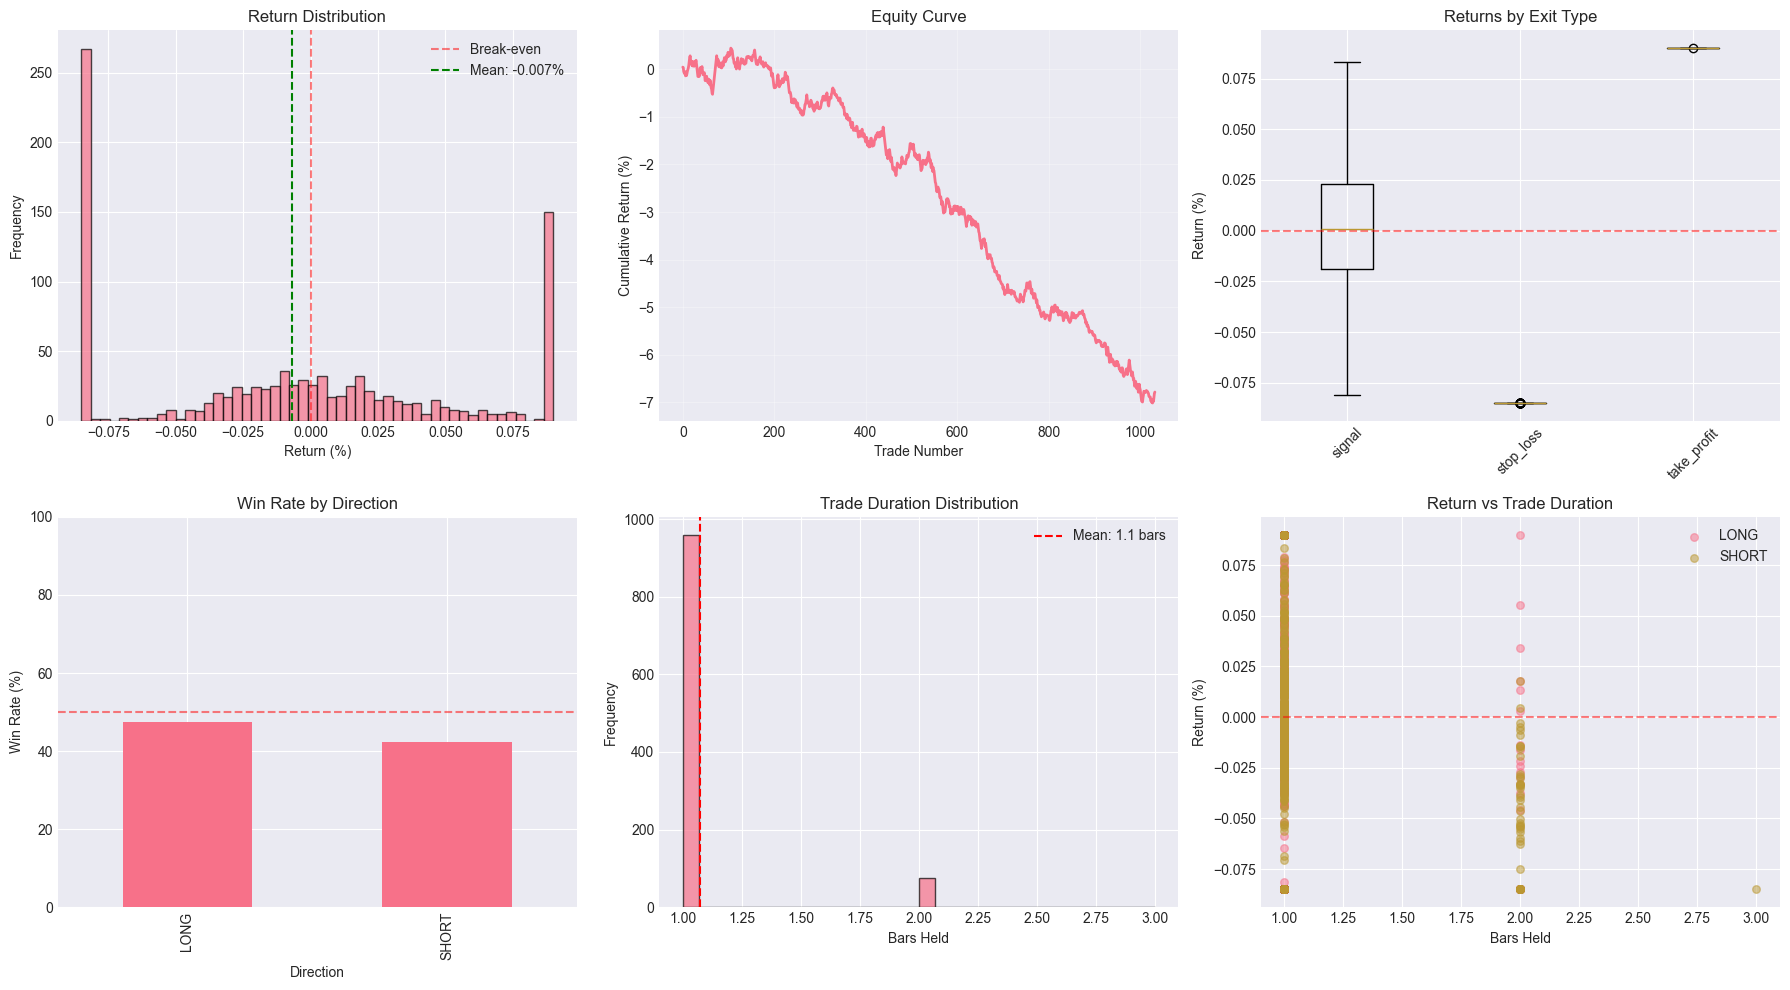

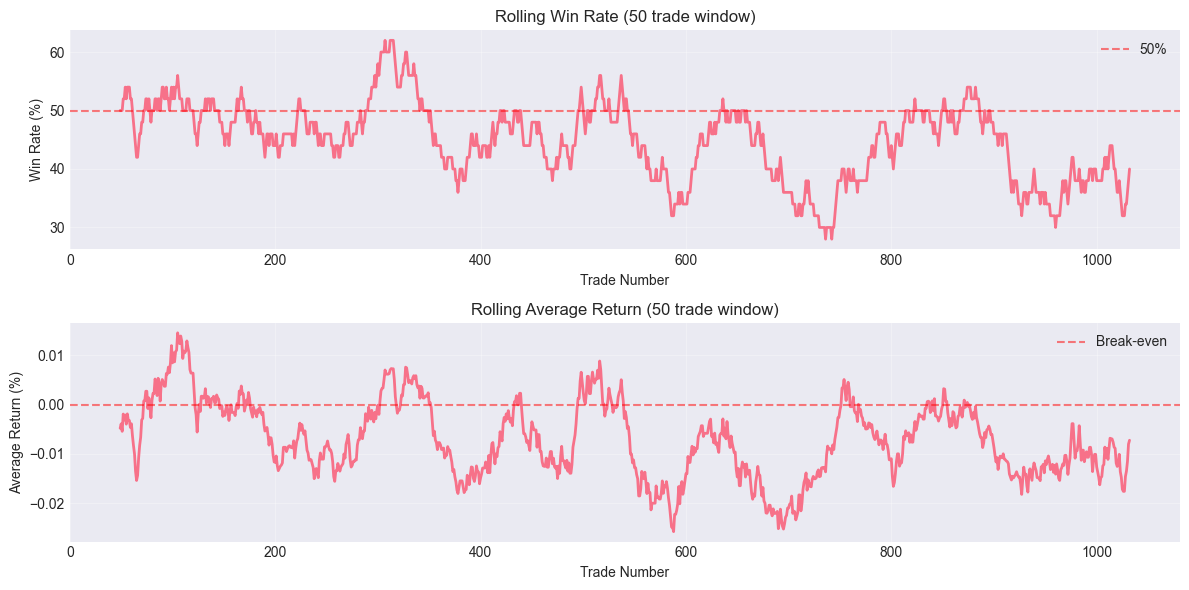

ModuleNotFoundError: No module named 'scipy'

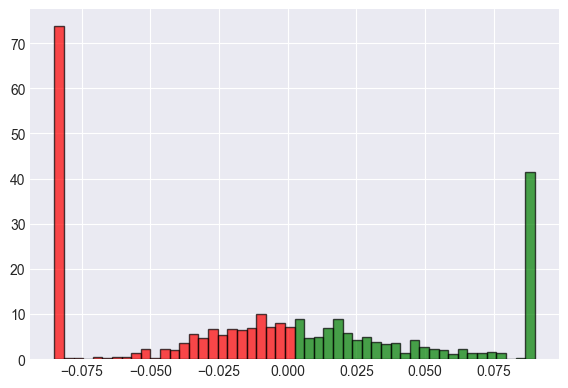

In [11]:
# Create performance visualizations
if trades_df is not None and len(trades_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. Return distribution
    ax = axes[0, 0]
    ax.hist(trades_df['net_return_pct'], bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5, label='Break-even')
    ax.axvline(trades_df['net_return_pct'].mean(), color='green', linestyle='--', label=f'Mean: {trades_df["net_return_pct"].mean():.3f}%')
    ax.set_xlabel('Return (%)')
    ax.set_ylabel('Frequency')
    ax.set_title('Return Distribution')
    ax.legend()
    
    # 2. Cumulative returns
    ax = axes[0, 1]
    cumulative_returns = (1 + trades_df['net_return_pct']/100).cumprod()
    cumulative_pct = (cumulative_returns - 1) * 100
    ax.plot(cumulative_pct.values, linewidth=2)
    ax.set_xlabel('Trade Number')
    ax.set_ylabel('Cumulative Return (%)')
    ax.set_title('Equity Curve')
    ax.grid(True, alpha=0.3)
    
    # 3. Returns by exit type
    ax = axes[0, 2]
    exit_types = trades_df['exit_type'].unique()
    returns_by_exit = [trades_df[trades_df['exit_type'] == et]['net_return_pct'].values for et in exit_types]
    ax.boxplot(returns_by_exit, labels=exit_types)
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_ylabel('Return (%)')
    ax.set_title('Returns by Exit Type')
    ax.tick_params(axis='x', rotation=45)
    
    # 4. Win rate by direction
    ax = axes[1, 0]
    direction_stats = trades_df.groupby('direction').agg({
        'is_winner': 'mean'
    }) * 100
    direction_stats.plot(kind='bar', ax=ax, legend=False)
    ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
    ax.set_xlabel('Direction')
    ax.set_ylabel('Win Rate (%)')
    ax.set_title('Win Rate by Direction')
    ax.set_ylim(0, 100)
    
    # 5. Trade duration distribution
    ax = axes[1, 1]
    ax.hist(trades_df['bars_held'], bins=30, alpha=0.7, edgecolor='black')
    ax.axvline(trades_df['bars_held'].mean(), color='red', linestyle='--', 
                label=f'Mean: {trades_df["bars_held"].mean():.1f} bars')
    ax.set_xlabel('Bars Held')
    ax.set_ylabel('Frequency')
    ax.set_title('Trade Duration Distribution')
    ax.legend()
    
    # 6. Return vs bars held scatter
    ax = axes[1, 2]
    for direction in ['LONG', 'SHORT']:
        dir_trades = trades_df[trades_df['direction'] == direction]
        ax.scatter(dir_trades['bars_held'], dir_trades['net_return_pct'], 
                   alpha=0.5, label=direction, s=30)
    ax.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Bars Held')
    ax.set_ylabel('Return (%)')
    ax.set_title('Return vs Trade Duration')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization: Rolling performance
    if len(trades_df) >= 20:
        plt.figure(figsize=(12, 6))
        
        # Rolling win rate
        window = min(50, len(trades_df) // 4)
        rolling_win_rate = trades_df['is_winner'].rolling(window).mean() * 100
        
        plt.subplot(2, 1, 1)
        plt.plot(rolling_win_rate.values, linewidth=2)
        plt.axhline(50, color='red', linestyle='--', alpha=0.5, label='50%')
        plt.xlabel('Trade Number')
        plt.ylabel('Win Rate (%)')
        plt.title(f'Rolling Win Rate ({window} trade window)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Rolling average return
        plt.subplot(2, 1, 2)
        rolling_avg_return = trades_df['net_return_pct'].rolling(window).mean()
        plt.plot(rolling_avg_return.values, linewidth=2)
        plt.axhline(0, color='red', linestyle='--', alpha=0.5, label='Break-even')
        plt.xlabel('Trade Number')
        plt.ylabel('Average Return (%)')
        plt.title(f'Rolling Average Return ({window} trade window)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    # NEW: Detailed Return Distribution Analysis
    plt.figure(figsize=(15, 10))
    
    # 1. Return distribution with KDE
    plt.subplot(2, 2, 1)
    n, bins, patches = plt.hist(trades_df['net_return_pct'], bins=50, density=True, alpha=0.7, edgecolor='black')
    
    # Color bars based on positive/negative returns
    for i in range(len(patches)):
        if bins[i] >= 0:
            patches[i].set_facecolor('green')
        else:
            patches[i].set_facecolor('red')
    
    # Add KDE overlay
    from scipy import stats
    kde = stats.gaussian_kde(trades_df['net_return_pct'])
    x_range = np.linspace(trades_df['net_return_pct'].min(), trades_df['net_return_pct'].max(), 100)
    plt.plot(x_range, kde(x_range), 'b-', linewidth=2, label='KDE')
    
    plt.axvline(0, color='black', linestyle='--', alpha=0.5, label='Break-even')
    plt.axvline(trades_df['net_return_pct'].mean(), color='blue', linestyle='--', label=f'Mean: {trades_df["net_return_pct"].mean():.3f}%')
    plt.axvline(trades_df['net_return_pct'].median(), color='orange', linestyle='--', label=f'Median: {trades_df["net_return_pct"].median():.3f}%')
    plt.xlabel('Return (%)')
    plt.ylabel('Density')
    plt.title('Return Distribution with KDE')
    plt.legend()
    
    # 2. Return distribution by exit type
    plt.subplot(2, 2, 2)
    exit_types = trades_df['exit_type'].unique()
    for i, exit_type in enumerate(exit_types):
        et_returns = trades_df[trades_df['exit_type'] == exit_type]['net_return_pct']
        plt.hist(et_returns, bins=30, alpha=0.5, label=f'{exit_type} (n={len(et_returns)})', density=True)
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Return (%)')
    plt.ylabel('Density')
    plt.title('Return Distribution by Exit Type')
    plt.legend()
    
    # 3. Q-Q plot for each direction
    plt.subplot(2, 2, 3)
    for direction in ['LONG', 'SHORT']:
        dir_trades = trades_df[trades_df['direction'] == direction]
        if len(dir_trades) > 5:
            stats.probplot(dir_trades['net_return_pct'], dist="norm", plot=plt)
    plt.title('Q-Q Plot by Direction')
    
    # 4. Box plot with outliers
    plt.subplot(2, 2, 4)
    box_data = []
    box_labels = []
    for exit_type in trades_df['exit_type'].unique():
        et_returns = trades_df[trades_df['exit_type'] == exit_type]['net_return_pct']
        if len(et_returns) > 0:
            box_data.append(et_returns)
            box_labels.append(f'{exit_type}\n(n={len(et_returns)})')
    
    bp = plt.boxplot(box_data, labels=box_labels, showfliers=True, patch_artist=True)
    
    # Color boxes based on median return
    for i, (box, data) in enumerate(zip(bp['boxes'], box_data)):
        if np.median(data) > 0:
            box.set_facecolor('lightgreen')
        else:
            box.set_facecolor('lightcoral')
    
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.ylabel('Return (%)')
    plt.title('Return Distribution by Exit Type (with outliers)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary table
    print("\n=== Return Distribution Statistics ===")
    print(f"Mean: {trades_df['net_return_pct'].mean():.4f}%")
    print(f"Median: {trades_df['net_return_pct'].median():.4f}%")
    print(f"Std Dev: {trades_df['net_return_pct'].std():.4f}%")
    print(f"Skewness: {stats.skew(trades_df['net_return_pct']):.4f}")
    print(f"Kurtosis: {stats.kurtosis(trades_df['net_return_pct']):.4f}")
    
    # Percentile analysis
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    print("\nPercentile Analysis:")
    for p in percentiles:
        val = np.percentile(trades_df['net_return_pct'], p)
        print(f"  {p}th percentile: {val:.4f}%")
    
    # Tail analysis
    print(f"\nTail Analysis:")
    print(f"  Returns < -0.1%: {(trades_df['net_return_pct'] < -0.1).sum()} trades ({(trades_df['net_return_pct'] < -0.1).mean()*100:.1f}%)")
    print(f"  Returns > 0.1%: {(trades_df['net_return_pct'] > 0.1).sum()} trades ({(trades_df['net_return_pct'] > 0.1).mean()*100:.1f}%)")
    print(f"  Returns between -0.01% and 0.01%: {((trades_df['net_return_pct'] > -0.01) & (trades_df['net_return_pct'] < 0.01)).sum()} trades")

## 8. Order Flow Analysis

### 5. Risk Exit Analysis
Validate that stop losses and take profits are working correctly.

# Validate risk exits
validation_results = validate_risk_exits(trades)

# Show exit type distribution
exit_counts = trades['exit_type'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Exit type pie chart
ax1.pie(exit_counts.values, labels=exit_counts.index, autopct='%1.1f%%')
ax1.set_title('Exit Type Distribution')

# Returns by exit type
exit_returns = trades.groupby('exit_type')['net_return_pct'].agg(['mean', 'count'])
x = range(len(exit_returns))
ax2.bar(x, exit_returns['mean'])
ax2.set_xticks(x)
ax2.set_xticklabels(exit_returns.index, rotation=45)
ax2.set_ylabel('Average Return %')
ax2.set_title('Average Return by Exit Type')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add count labels
for i, (idx, row) in enumerate(exit_returns.iterrows()):
    ax2.text(i, row['mean'] + 0.01, f"n={row['count']}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Show validation warnings if any
if validation_results['warnings']:
    print("\n⚠️ Risk Exit Validation Warnings:")
    for warning in validation_results['warnings']:
        print(f"  - {warning}")
else:
    print("\n✅ All risk exits appear to be functioning correctly")

# Show detailed stats by direction and exit type
print("\n=== Returns by Direction and Exit Type ===")
for direction in ['LONG', 'SHORT']:
    dir_trades = trades[trades['direction'] == direction]
    if len(dir_trades) > 0:
        print(f"\n{direction} Positions:")
        exit_stats = dir_trades.groupby('exit_type')['net_return_pct'].agg(['mean', 'count'])
        print(exit_stats)

### 6. Return Distribution Analysis
Analyze the distribution of returns and identify outliers.

# Return distribution analysis
returns = trades['net_return_pct'].values

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Return distribution histogram
ax = axes[0, 0]
n_bins = min(50, len(returns) // 10)
ax.hist(returns, bins=n_bins, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax.axvline(x=returns.mean(), color='green', linestyle='-', alpha=0.7, label=f'Mean: {returns.mean():.3f}%')
ax.set_xlabel('Return %')
ax.set_ylabel('Frequency')
ax.set_title('Return Distribution')
ax.legend()

# 2. Cumulative returns
ax = axes[0, 1]
cumulative_returns = (1 + returns/100).cumprod() - 1
ax.plot(cumulative_returns * 100)
ax.set_xlabel('Trade Number')
ax.set_ylabel('Cumulative Return %')
ax.set_title('Cumulative Returns')
ax.grid(True, alpha=0.3)

# 3. Returns by direction
ax = axes[1, 0]
for direction in ['LONG', 'SHORT']:
    dir_returns = trades[trades['direction'] == direction]['net_return_pct']
    if len(dir_returns) > 0:
        ax.hist(dir_returns, bins=30, alpha=0.5, label=f'{direction} (n={len(dir_returns)})', edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('Return %')
ax.set_ylabel('Frequency')
ax.set_title('Returns by Direction')
ax.legend()

# 4. Q-Q plot for normality check
ax = axes[1, 1]
from scipy import stats
stats.probplot(returns, dist="norm", plot=ax)
ax.set_title('Q-Q Plot (Normality Test)')

plt.tight_layout()
plt.show()

# Statistical summary
print("\n=== Return Distribution Statistics ===")
print(f"Mean: {returns.mean():.4f}%")
print(f"Median: {np.median(returns):.4f}%")
print(f"Std Dev: {returns.std():.4f}%")
print(f"Skewness: {stats.skew(returns):.4f}")
print(f"Kurtosis: {stats.kurtosis(returns):.4f}")
print(f"Sharpe Ratio: {returns.mean() / returns.std() * np.sqrt(252):.4f}")  # Annualized

# Identify outliers
q1, q3 = np.percentile(returns, [25, 75])
iqr = q3 - q1
outlier_threshold = 1.5 * iqr
outliers = trades[(returns < q1 - outlier_threshold) | (returns > q3 + outlier_threshold)]

if len(outliers) > 0:
    print(f"\n⚠️ Found {len(outliers)} outlier trades ({len(outliers)/len(trades)*100:.1f}%):")
    print(outliers[['entry_time', 'exit_time', 'direction', 'net_return_pct', 'exit_type']].head(10))

In [12]:
# Analyze effectiveness of risk management
if 'position_close' in traces and 'realized_pnl' in traces['position_close'].columns:
    pos_close = traces['position_close']
    
    print("=== Risk Management Effectiveness ===")
    
    # Calculate metrics
    total_trades = len(pos_close)
    profitable_trades = (pos_close['realized_pnl'] > 0).sum() if 'realized_pnl' in pos_close.columns else 0
    
    if total_trades > 0:
        win_rate = profitable_trades / total_trades * 100
        avg_win = pos_close[pos_close['realized_pnl'] > 0]['realized_pnl'].mean() if profitable_trades > 0 else 0
        avg_loss = pos_close[pos_close['realized_pnl'] < 0]['realized_pnl'].mean() if (total_trades - profitable_trades) > 0 else 0
        
        print(f"Total trades: {total_trades}")
        print(f"Win rate: {win_rate:.1f}%")
        print(f"Average win: ${avg_win:.2f}")
        print(f"Average loss: ${avg_loss:.2f}")
        
        if avg_loss != 0:
            profit_factor = abs(avg_win / avg_loss)
            print(f"Profit factor: {profit_factor:.2f}")
        
        # Analyze by exit type
        if 'exit_type' in pos_close.columns:
            print("\nWin rate by exit type:")
            for exit_type, group in pos_close.groupby('exit_type'):
                wins = (group['realized_pnl'] > 0).sum()
                total = len(group)
                win_pct = wins / total * 100 if total > 0 else 0
                print(f"  {exit_type}: {win_pct:.1f}% ({wins}/{total})")

=== Risk Management Effectiveness ===
Total trades: 1033
Win rate: 52.7%
Average win: $0.28
Average loss: $-0.28
Profit factor: 1.00

Win rate by exit type:
  signal: 64.0% (394/616)
  stop_loss: 0.0% (0/267)
  take_profit: 100.0% (150/150)


# Summary statistics
print("=== Execution Summary ===")
print(f"Total orders: {len(data['orders'])}")
print(f"Total fills: {len(data['fills'])}")
print(f"Total trades: {len(trades)}")
print(f"\nPerformance Metrics:")
print(f"Total Return: {trades['net_return_pct'].sum():.2f}%")
print(f"Win Rate: {(trades['net_return_pct'] > 0).mean() * 100:.1f}%")
print(f"Average Return per Trade: {trades['net_return_pct'].mean():.4f}%")
print(f"Best Trade: {trades['net_return_pct'].max():.4f}%")
print(f"Worst Trade: {trades['net_return_pct'].min():.4f}%")
print(f"\nRisk Metrics:")
print(f"Return Std Dev: {trades['net_return_pct'].std():.4f}%")
print(f"Downside Deviation: {trades[trades['net_return_pct'] < 0]['net_return_pct'].std():.4f}%")
print(f"Max Drawdown: {(cumulative_returns.cummax() - cumulative_returns).max() * 100:.2f}%")

# Direction breakdown
print(f"\nBy Direction:")
for direction in ['LONG', 'SHORT']:
    dir_trades = trades[trades['direction'] == direction]
    if len(dir_trades) > 0:
        print(f"\n{direction} ({len(dir_trades)} trades):")
        print(f"  Total Return: {dir_trades['net_return_pct'].sum():.2f}%")
        print(f"  Win Rate: {(dir_trades['net_return_pct'] > 0).mean() * 100:.1f}%")
        print(f"  Avg Return: {dir_trades['net_return_pct'].mean():.4f}%")

# Execution cost impact
total_exec_cost = len(trades) * execution_cost_bps / 100
print(f"\nExecution Cost Impact:")
print(f"Total Execution Cost: {total_exec_cost:.2f}%")
print(f"Avg Cost per Trade: {execution_cost_bps / 100:.3f}%")

# Export results if needed
output_file = f"trade_analysis_{strategy_hash[:8]}.csv"
trades.to_csv(output_file, index=False)
print(f"\nTrade details exported to: {output_file}")

In [13]:
print("=== SUMMARY ===")
print(f"\nData Quality:")
for key, df in traces.items():
    print(f"  {key}: {len(df)} records")

print(f"\nKey Findings:")
if 'orders' in traces and 'fills' in traces:
    print(f"  - Order fill rate: {len(traces['fills'])/len(traces['orders'])*100:.1f}%")

if 'position_close' in traces and 'exit_type' in traces['position_close'].columns:
    risk_exits = traces['position_close']['exit_type'].isin(['stop_loss', 'take_profit', 'trailing_stop']).sum()
    print(f"  - Risk management exits: {risk_exits} ({risk_exits/len(traces['position_close'])*100:.1f}%)")

print("\n=== RECOMMENDATIONS ===")
print("1. Check for immediate re-entry after risk exits")
print("2. Analyze signal persistence after stop-loss exits")
print("3. Consider implementing a 'cooldown' period after risk exits")
print("4. Review risk parameters if too many stop-loss exits")

=== SUMMARY ===

Data Quality:

Key Findings:

=== RECOMMENDATIONS ===
1. Check for immediate re-entry after risk exits
2. Analyze signal persistence after stop-loss exits
3. Consider implementing a 'cooldown' period after risk exits
4. Review risk parameters if too many stop-loss exits


In [13]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/execution_trace_analysis.py


EXECUTION ENGINE TRADE-BY-TRADE ANALYSIS

Extracting trades from execution traces...
ERROR: fills_df and positions_df not found in notebook context
Please ensure you have loaded the execution traces before running this cell

Expected DataFrames:
- fills_df: DataFrame with fill events from execution
- positions_df: DataFrame with position events
- orders_df (optional): DataFrame with order events


In [14]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/load_and_analyze_execution.py

Loading execution traces from: /Users/daws/ADMF-PC/config/bollinger/results/latest


KeyError: 'timestamp'

In [15]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/load_and_analyze_execution.py

Loading execution traces from: /Users/daws/ADMF-PC/config/bollinger/results/latest
✅ Loaded 2066 fills


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [16]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/simple_execution_analysis.py

Loading fills...
✅ Loaded 2066 fills
Columns: ['idx', 'ts', 'sym', 'metadata', 'timestamp']

First 5 fills:
   idx                          ts     sym  \
0   27  2025-06-29T09:43:10.787592  SPY_5m   
1   28  2025-06-29T09:43:10.788548  SPY_5m   
2   28  2025-06-29T09:43:10.788976  SPY_5m   
3   29  2025-06-29T09:43:10.789663  SPY_5m   
4   71  2025-06-29T09:43:10.802136  SPY_5m   

                                            metadata  \
0  {'commission': '0.0', 'executed_at': '2025-06-...   
1  {'commission': '0.0', 'executed_at': '2025-06-...   
2  {'commission': '0.0', 'executed_at': '2025-06-...   
3  {'commission': '0.0', 'executed_at': '2025-06-...   
4  {'commission': '0.0', 'executed_at': '2025-06-...   

                   timestamp  
0 2025-06-29 09:43:10.787592  
1 2025-06-29 09:43:10.788548  
2 2025-06-29 09:43:10.788976  
3 2025-06-29 09:43:10.789663  
4 2025-06-29 09:43:10.802136  


ZeroDivisionError: float division by zero

In [17]:
%run /Users/daws/ADMF-PC/src/analytics/snippets/simple_execution_analysis.py

Loading fills...
✅ Loaded 2066 fills
Columns: ['idx', 'ts', 'sym', 'metadata', 'timestamp']

First 5 fills:
   idx                          ts     sym  \
0   27  2025-06-29T09:43:10.787592  SPY_5m   
1   28  2025-06-29T09:43:10.788548  SPY_5m   
2   28  2025-06-29T09:43:10.788976  SPY_5m   
3   29  2025-06-29T09:43:10.789663  SPY_5m   
4   71  2025-06-29T09:43:10.802136  SPY_5m   

                                            metadata  \
0  {'commission': '0.0', 'executed_at': '2025-06-...   
1  {'commission': '0.0', 'executed_at': '2025-06-...   
2  {'commission': '0.0', 'executed_at': '2025-06-...   
3  {'commission': '0.0', 'executed_at': '2025-06-...   
4  {'commission': '0.0', 'executed_at': '2025-06-...   

                   timestamp  
0 2025-06-29 09:43:10.787592  
1 2025-06-29 09:43:10.788548  
2 2025-06-29 09:43:10.788976  
3 2025-06-29 09:43:10.789663  
4 2025-06-29 09:43:10.802136  

EXECUTION ENGINE TRADE-BY-TRADE ANALYSIS

Found 100 trades

First 30 trades from EXECUTION 